# 영화리뷰 텍스트 감성분석하기

## 1. 텍스트 데이터의 특징

### 1.1 텍스트를 숫자로 표현하는 방법

단어와 그 단어의 의미를 나타내는 벡터를 짝지어 본다.

아래의 문장을 예시로 텍스트 데이터를 처리해본다.
- i feel hungry
- i eat lunch
- now i feel happy

In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담는다.
sentences = ['i feel hungry', 'i eat lunch', 'now i feel happy']

# 단어 단위로 문장을 쪼개기
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


사전을 만들기 위해 모든 문장을 단어 단위로 나누고, 파이썬 딕셔너리 자료구조로 표현한다.

In [2]:
index_to_word = {}

# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어준다.
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


데이터를 숫자로 바꾸기 위헤 딕셔너리를 {텍스트:인덱스} 구조로 변경한다.

In [3]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)
print(word_to_index['feel']) # 단어 'feel'은 숫자 인덱스 4로 바뀐다

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}
4


문장을 input으로 주면, 단어 인덱스 리스트로 변환해 주는 함수 만들기(모든 문장은 <BOS>로 시작하는 것으로 한다.)

In [4]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else  word_to_index['<UNK>'] for word in sentence.split()]
print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


여러 개의 문장 리스트를 한번에 숫자 텐서로 encode 해주는 함수

In [5]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


반대로, 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 

In [6]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


여러 개의 숫자 벡터로 encode된 문장을 한번에 decode하는 함수

In [7]:
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


### 1.2 Embedding 레이어의 등장

우리가 하려는 것은 단어와 그 단어의 의미를 나타내는 벡터를 짝짓는 것. 단어의 의미를 나타내는 벡터를 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해 최적화한다.
Tensorflow, Pytorch 등의 딥러닝 프레임워크들은 이러한 의미벡터 파라미터를 구현한 Embedding 레이어를 제공한다.

> embedding 레이어의 __인풋__ 이 되는 문장 벡터는 그 __길이가 일정__ 해야 한다.
(Tensorflow에서는 keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


tf.Tensor(
[[[ 0.02907392  0.02859164 -0.0419425   0.00335587]
  [-0.03963291  0.01236938 -0.04840344 -0.00640609]
  [ 0.00242843  0.02733065 -0.00914029  0.04297358]
  [ 0.0333668   0.00268817 -0.03770499  0.03853634]
  [-0.0478671  -0.00416014 -0.03783959  0.00587008]]

 [[ 0.02907392  0.02859164 -0.0419425   0.00335587]
  [-0.03963291  0.01236938 -0.04840344 -0.00640609]
  [ 0.00338869  0.04658907 -0.04785929  0.01763048]
  [-0.04648193 -0.04934604 -0.00517305  0.0009892 ]
  [-0.0478671  -0.00416014 -0.03783959  0.00587008]]

 [[ 0.02907392  0.02859164 -0.0419425   0.00335587]
  [ 0.01375936  0.0402511  -0.03943772 -0.0057791 ]
  [-0.03963291  0.01236938 -0.04840344 -0.00640609]
  [ 0.00242843  0.02733065 -0.00914029  0.04297358]
  [ 0.02006575 -0.04041693 -0.01075566 -0.01085861]]], shape=(3, 5, 4), dtype=float32)


👀 shape=(3,5,4) 각 숫자의 의미는?
- 3은 입력문장 개수
- 5는 입력문장의 최대 길이
- 4는 워드 벡터의 차원 수

## 2. 시퀀스 데이터를 다루는 RNN

RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계


!['stateful/stateless'](https://image.slidesharecdn.com/webhttprest-120910201409-phpapp02-130121190926-phpapp02/95/-49-1024.jpg?cb=1358795626)

RNN 모델을 사용하여 이전 스템의 텍스트 데이터를 처리하는 코드

In [9]:
vocab_size = 10 # 어휘 사전의 크기
word_vector_dim = 4 # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


## 3. CNN

- 텍스트 처리를 하기위해 `1-D Convolution Neural Netword(1-D CNN)`를 사용할 수 있다.
- `1-D CNN`은 문장 체페를 한꺼번에 한 방향으로 길이 n짜리 필터로 스캐닝 하면서 n단어 이내에서 발견되는 특징을 추출하고, 그것으로 문장을 분류하는 방식으로 사용된다.
- CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다.

In [10]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

아주 간단하게는 `GlobalMaxPooling1D()` 레이어 하나만 사용할 수 도 있다. 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍/부정을 평가하는 방식이다.

In [11]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## 4. IMDb 영화리뷰 감성분석

### 4.1 IMDB 데이터셋 분석

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000) # 10,000개의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.4.1


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 개수: 25000, 테스트 개수: 25000


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [13]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [14]:
# imdb 데이터셋에는 encode에 사용한 딕셔너리를 제공한다
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [15]:
# IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word 보정
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [16]:
# decode 테스트
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

`pad_sequences`를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안된다. 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 적절한 값을 찾기 위해서는 전체 데이터 셋의 분포를 확인해 보는 것이 좋다.

In [17]:
# 텍스트데이터 문장을 담은 리스트 생성
total_data_text = list(x_train) + list(x_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pos'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율 적. 따라서 'pre' 가 훨씬 유리하다.

### 4.2 딥러닝 모델 설계와 훈련

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [20]:
# train, validation set 분리

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [21]:
# 모델 학습 시작
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 51ms/step - loss: 0.6926 - accuracy: 0.5041 - val_loss: 0.6904 - val_accuracy: 0.5069
Epoch 2/20
30/30 [==============================] - 1s 35ms/step - loss: 0.6884 - accuracy: 0.5604 - val_loss: 0.6833 - val_accuracy: 0.7404
Epoch 3/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6792 - accuracy: 0.7826 - val_loss: 0.6674 - val_accuracy: 0.7978
Epoch 4/20
30/30 [==============================] - 1s 30ms/step - loss: 0.6565 - accuracy: 0.8230 - val_loss: 0.6330 - val_accuracy: 0.7989
Epoch 5/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6124 - accuracy: 0.8334 - val_loss: 0.5807 - val_accuracy: 0.8101
Epoch 6/20
30/30 [==============================] - 1s 30ms/step - loss: 0.5494 - accuracy: 0.8458 - val_loss: 0.5183 - val_accuracy: 0.8200
Epoch 7/20
30/30 [==============================] - 1s 30ms/step - loss: 0.4779 - accuracy: 0.8535 - val_loss: 0.4618 - val_accuracy: 0.8303
Epoch 8/20
30

In [22]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, None) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
embedding_4 (None, None) float32
global_max_pooling1d_2 (None, None, 16) float32
dense_6 (None, 16) float32
dense_7 (None, 8) float32


[None, None, None, None]

In [23]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 3s - loss: 0.3630 - accuracy: 0.8461
[0.36302122473716736, 0.8460800051689148]


In [24]:
# history 변수에 model.fit 과정 중 train/val loss, accuracy 등 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


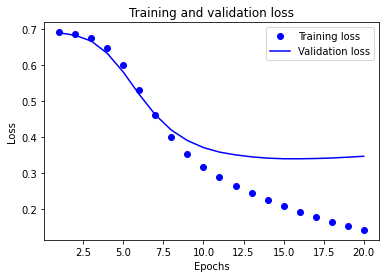

In [25]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

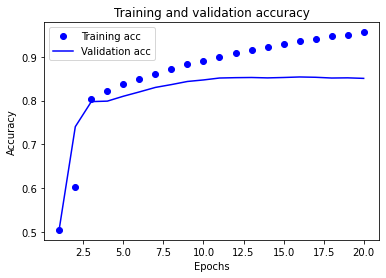

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training and validation loss, accuracy를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있다.

### 4.3 Word2Vec의 적용

- 워드임베딩: 감성분석의 비용을 절감하면서 정확도를 향상시킬 수 있는 자연어처리 기법

In [27]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [28]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
# 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.03590291, -0.03991875, -0.02156213, -0.02783189, -0.039451  ,
       -0.04158521, -0.02779803, -0.03943876, -0.02372722, -0.03866684,
       -0.03283311, -0.02591353, -0.01387497, -0.02491677, -0.03144612,
       -0.02474207], dtype=float32)

워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하기위해 유사도를 확인해본다.

In [30]:
word_vectors.similar_by_word("love")

[('arguably', 0.9932642579078674),
 ('cats', 0.9891701340675354),
 ('award', 0.9884845614433289),
 ('contrast', 0.9874439239501953),
 ('favourite', 0.9862301349639893),
 ('simple', 0.9850082397460938),
 ('dirty', 0.9842315912246704),
 ('joins', 0.9822598695755005),
 ('noir', 0.9818346500396729),
 ('meadows', 0.9797354936599731)]

그리 좋은 결과는 아니다.. 우리가 다룬 정도의 훈련데이터로는 워드 벡터를 정교하게 학습시키기 어렵다.

따라서 구글에서 제공하는 `Word2Vec`이라는 사전학습된 워드 임베딩 모델을 활용해본다.
> __임베딩__<br>
    임베딩(embedding)은 자연어를 숫자의 나열인 벡터로 바꾼 결과 혹은 그 일련의 과정 전체를 가리키는 용어입니다. 단어나 문장 각각을 벡터로 변환해 벡터 공간에 ‘끼워 넣는다(embed)’는 취지에서 임베딩이라는 이름이 붙었습니다.
    임베딩에는 말뭉치(corpus)의 의미, 문법 정보가 응축돼 있습니다. 임베딩은 벡터이기 때문에 사칙연산이 가능하며, 단어/문서 관련도(relevance) 역시 계산할 수 있습니다.
    
> __전이학습__<br>
    전이 학습이란 특정 문제를 풀기 위해 학습한 모델을 다른 문제를 푸는 데 재사용하는 기법을 의미합니다. 예컨대 대규모 말뭉치를 미리 학습(pretrain)한 임베딩을 문서 분류 모델의 입력값으로 쓰고, 해당 임베딩을 포함한 모델 전체를 문서 분류 과제를 잘할 수 있도록 업데이트(fine-tuning)하는 방식

(https://ratsgo.github.io/natural%20language%20processing/2019/09/12/embedding/)

Word2Vec 모델을 가져와 적용해보자.

`$ ln -s ~/data/GoogleNews-vectors-negative300.bin.gz ~/aiffel/sentiment_classification/data`

In [31]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

메모리 에러 방지를 위해 `KeyedVectors.load_word2vec_format` 메소드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩하였다,
메모리가 충분하다면 `limit=None`으로 모두 로딩한다.

In [32]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.6618633270263672),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536839962005615),
 ('adores', 0.5440906882286072)]

이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜본다.

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [34]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [40]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20# 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=60,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
250/250 [==============================] - 18s 62ms/step - loss: 0.6805 - accuracy: 0.5368 - val_loss: 0.4164 - val_accuracy: 0.8155
Epoch 2/20
250/250 [==============================] - 14s 56ms/step - loss: 0.3622 - accuracy: 0.8418 - val_loss: 0.3450 - val_accuracy: 0.8494
Epoch 3/20
250/250 [==============================] - 14s 56ms/step - loss: 0.2197 - accuracy: 0.9203 - val_loss: 0.3256 - val_accuracy: 0.8682
Epoch 4/20
250/250 [==============================] - 14s 55ms/step - loss: 0.1314 - accuracy: 0.9595 - val_loss: 0.3560 - val_accuracy: 0.8650
Epoch 5/20
250/250 [==============================] - 14s 55ms/step - loss: 0.0722 - accuracy: 0.9817 - val_loss: 0.4105 - val_accuracy: 0.8622
Epoch 6/20
250/250 [==============================] - 14s 55ms/step - loss: 0.0313 - accuracy: 0.9951 - val_loss: 0.4873 - val_accuracy: 0.8579
Epoch 7/20
250/250 [==============================] - 14s 56ms/step - loss: 0.0150 - accuracy: 0.9987 - val_loss: 0.5227 - val_accuracy:

In [41]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 7s - loss: 0.9963 - accuracy: 0.8440
[0.996309220790863, 0.8440399765968323]
